In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, RandomCrop, RandomRotation, Normalize

from repath.utils.paths import project_root
import repath.data.datasets.camelyon16 as camelyon16
from repath.preprocess.tissue_detection import TissueDetectorOTSU
from repath.preprocess.patching import GridPatchFinder, SlidesIndex
from repath.preprocess.sampling import split_camelyon16, balanced_sample
from repath.preprocess.patching.apply_transform import ApplyTransforms, SingleTransform, LiuTransform
from torchvision.models import Inception3


In [2]:
experiment_name = "liu"
experiment_root = project_root() / "experiments" / experiment_name
tissue_detector = TissueDetectorOTSU()


In [3]:
train_data = camelyon16.training_small()
apply_transforms = LiuTransform(label = 2, num_transforms = 8)
#apply_transforms = SingleTransform()
#patch_finder = GridPatchFinder(labels_level=6, patch_level=0, patch_size=256, stride=256)
patch_finder = GridPatchFinder(labels_level=7, patch_level=0, patch_size=128, stride=128, apply_transforms= apply_transforms)
train_patches = SlidesIndex.index_dataset(train_data, tissue_detector, patch_finder)

indexing normal_038.tif
indexing tumor_048.tif
indexing normal_058.tif
indexing normal_115.tif
indexing tumor_111.tif
indexing normal_136.tif
indexing tumor_006.tif
indexing tumor_090.tif
indexing normal_129.tif
indexing normal_027.tif
indexing normal_052.tif
indexing normal_082.tif


In [4]:
train_patches

In [11]:
train_patches[1].patches_df

,x,y,label,transform
204762,1280,34304,1,1
522746,21760,87552,1,1
522820,31232,87552,1,1
524349,31360,87808,1,1
524352,31744,87808,1,1
...,...,...,...,...
1435,34560,197760,2,4
1436,34560,197760,2,5
1437,34560,197760,2,6
1438,34560,197760,2,7


In [6]:
import numpy as np
np.unique(train_patches[2].patches_df.label)

array([1])

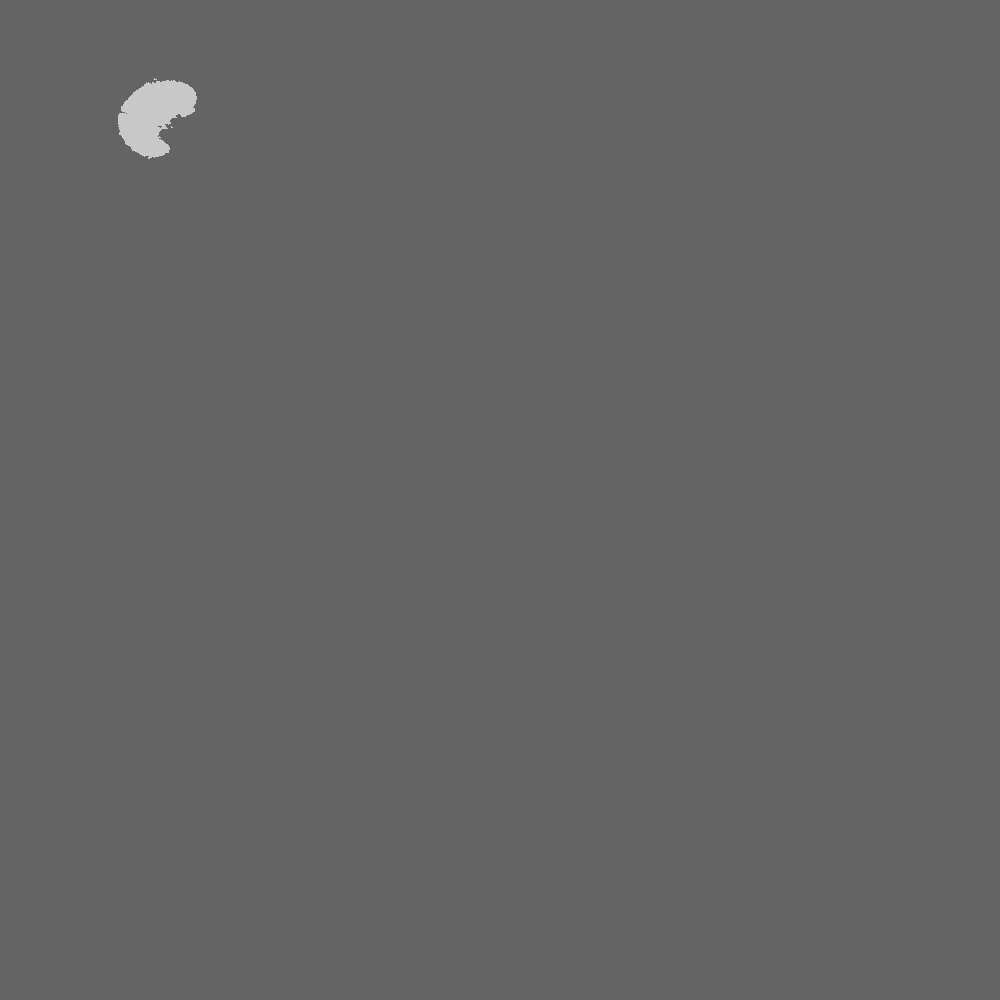

In [7]:
annotation_path = project_root()/ train_data.root/ train_data.paths.annotation.iloc[7]
annotations = train_data.load_annotations(annotation_path)

arr = annotations.render([1000,1000], 256)

from PIL import Image
Image.fromarray(arr.astype('uint8')* 100)


In [8]:
annotation_path

PosixPath('/home/ubuntu/repath/data/camelyon16/raw/training/lesion_annotations/tumor_090.xml')

In [9]:
slide_path = project_root()/ train_data.root/ train_data.paths.slide.iloc[7]
with train_data.slide_cls(slide_path) as slide:
    labels_shape = slide.dimensions[patch_finder.labels_level].as_shape()
    scale_factor = 2 ** patch_finder.labels_level
    labels_image = annotations.render(labels_shape, scale_factor)
    tissue_mask = tissue_detector(slide.get_thumbnail(patch_finder.labels_level))
    labels_image[~tissue_mask] = 0
    df, level, size = patch_finder(labels_image)
df

,x,y,label,transform
123523,49536,13312,1,1
123525,49792,13312,1,1
124708,49664,13440,1,1
124709,49792,13440,1,1
125891,49536,13568,1,1
...,...,...,...,...
112147,38272,40448,2,4
112148,38272,40448,2,5
112149,38272,40448,2,6
112150,38272,40448,2,7


In [10]:
np.unique(df.label)

array([1, 2])